### Imports

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

### Sample Maps

In [12]:
sample_map = {
    'qqZvvH125': 1,
    'qqWlvH125': 2,
    'Wbb': 3,
    'Wbc': 4,
    'Wcc': 5,
    'Wbl': 6,
    'Wcl': 7,
    'Wl': 8,
    'Zbb': 9,
    'Zbc': 10,
    'Zcc': 11,
    'Zbl': 12,
    'Zcl': 13,
    'Zl': 14,
    'ttbar': 15,
    'stopt': 16,
    'stops': 17,
    'stopWt': 18,
    'WW': 19,
    'ZZ': 20,
    'WZ': 21
}
sample_map_invert = dict(zip(sample_map.values(),sample_map.keys()))


reduce_map = {
    'qqZvvH125': 'VH',
    'qqWlvH125': 'VH',
    'Wbb': 'V+jets',
    'Wbc': 'V+jets',
    'Wcc': 'V+jets',
    'Wbl': 'V+jets',
    'Wcl': 'V+jets',
    'Wl': 'V+jets',
    'Zbb': 'V+jets',
    'Zbc': 'V+jets',
    'Zcc': 'V+jets',
    'Zbl': 'V+jets',
    'Zcl': 'V+jets',
    'Zl': 'V+jets',
    'ttbar': 'ttbar',
    'stopt': 'stop',
    'stops': 'stop',
    'stopWt': 'stop',
    'WW': 'diboson',
    'ZZ': 'diboson',
    'WZ': 'diboson'
}

reduced_sample_map = dict()

signal_zipped = dict(zip(range(1, 3), ['VH' for x in range(2)]))
Vjets_zipped = dict(zip(range(3, 15), ['V+jets' for x in range(12)]))
ttbar_zipped = {15: 'ttbar'}
stop_zipped = dict(zip(range(16, 19), ['stop' for x in range(3)]))
diboson_zipped = dict(zip(range(19, 22), ['diboson' for x in range(3)]))

reduced_sample_map.update(signal_zipped)
reduced_sample_map.update(Vjets_zipped)
reduced_sample_map.update(ttbar_zipped)
reduced_sample_map.update(stop_zipped)
reduced_sample_map.update(diboson_zipped)

branch_names = ["sample", "EventWeight", "EventNumber", "nJ", "nBJ", "mBB",
                "dRBB", "dPhiBB", "dEtaBB",
                "dPhiVBB", "dPhiLBmin", "Mtop", "dYWH", "dEtaWH",
                "dPhiLMET", "pTV", "pTB1", "pTB2", "pTL", "etaL",
                "mTW", "MET", "pTJ3", "mBBJ", "BDT"]

### Data Processing

In [34]:
# Read in NTuple data from pre-processed CSV file.
df = pd.read_csv('/Volumes/THUMB/VHbb-data/CSV/VHbb_data_preselect.csv', index_col=0)

# Split into 2 jet and 3 jet trainings.
df_2jet = df[df['nJ'] == 2]
df_3jet = df[df['nJ'] == 3]

# Classification array for these DFs.
classification_2jet = df_2jet['Class'].as_matrix()
classification_3jet = df_3jet['Class'].as_matrix()

# Drop unneeded columns for the training.
df_2jet_filtered = df_2jet.drop(['sample','EventWeight','nJ','nBJ', 'dEtaBB', 'dPhiBB',
                                 'dEtaWH', 'dPhiLMET', 'BDT', 'pTL', 'etaL', 'Class',
                                 'mBBJ', 'pTJ3'], axis=1)
df_3jet_filtered = df_3jet.drop(['sample','EventWeight','nJ','nBJ', 'dEtaBB', 'dPhiBB',
                                 'dEtaWH', 'dPhiLMET', 'BDT', 'pTL', 'etaL', 'Class'], axis=1)

# Convert to ndarray. All elements will be recast as floats.
dataset_2jet = df_2jet_filtered.as_matrix()
dataset_3jet = df_3jet_filtered.as_matrix()

# Split into training and test sets.
train_2jet, test_2jet, train_2jet_class, test_2jet_class = train_test_split(dataset_2jet,
                                                                            classification_2jet,
                                                                            test_size=0.25,
                                                                            random_state=42)

train_3jet, test_3jet, train_3jet_class, test_3jet_class = train_test_split(dataset_3jet,
                                                                            classification_3jet,
                                                                            test_size=0.25,
                                                                            random_state=42)

# Preserve event numbers of train and test sets, then drop from training and test sets.

train_2jet_event_nos = train_2jet[:, 0].astype(int)
train_3jet_event_nos = train_3jet[:, 0].astype(int)
test_2jet_event_nos = test_2jet[:, 0].astype(int)
test_3jet_event_nos = test_3jet[:, 0].astype(int)

train_2jet = np.delete(train_2jet, 0, 1)
train_3jet = np.delete(train_3jet, 0, 1)
test_2jet = np.delete(test_2jet, 0, 1)
test_3jet = np.delete(test_3jet, 0, 1)

# Map event numbers to process type numbers and event weights.
event_to_process_nos = pd.Series(df['sample'].as_matrix(), index=df['EventNumber'].as_matrix()).to_dict()
event_to_weight = pd.Series(df['EventWeight'].as_matrix(), index=df['EventNumber'].as_matrix()).to_dict()

test_2jet_process_nos = map(lambda a: event_to_process_nos[a],test_2jet_event_nos)
test_3jet_process_nos = map(lambda a: event_to_process_nos[a],test_3jet_event_nos)

# Map process types numbers to process type groups.
# Note that this is a convoluted process and could be
# simplified at a later date...
test_2jet_processes = np.array(map(lambda a: sample_map_invert[a], test_2jet_process_nos))
test_3jet_processes = np.array(map(lambda a: sample_map_invert[a], test_3jet_process_nos))

# Map event numbers to event weights.
train_2jet_weights = np.array(map(lambda a: event_to_weight[a], train_2jet_event_nos))
train_3jet_weights = np.array(map(lambda a: event_to_weight[a], train_3jet_event_nos))

In [35]:
pd.set_option('display.max_columns', 500)
#df_2jet[df_2jet['sample'] == 2]

pd.DataFrame(train_2jet)

,0,1,2,3,4,5,6,7,8,9,10
0,60.709183,0.636281,3.102982,2.689632,227398.796875,0.215609,163017.296875,113.920799,45.886208,92556.281250,12.258785
1,175.000000,2.393039,3.114517,1.064892,237051.234375,0.833400,213579.890625,235.788483,41.916172,29588.871094,30.685072
2,164.205551,2.470013,3.135978,0.746292,147570.281250,0.793714,223893.843750,239.294937,26.577745,30546.070312,11.005223
3,175.000000,2.218867,3.099311,2.055616,284300.781250,0.138412,202387.671875,233.693863,117.410759,5672.959473,135.056183
4,145.465347,2.642636,3.120197,0.669643,178408.328125,0.658314,167406.734375,130.784851,26.447622,50721.503906,102.354271
5,123.209587,1.654182,3.042073,1.469102,178371.703125,0.359550,179330.359375,122.441849,40.445591,80673.039062,132.245041
6,123.477859,1.076074,3.110756,2.318507,247606.875000,0.152177,231984.421875,201.748779,66.809166,15461.848633,53.431549
7,66.783287,0.652362,3.113883,3.011475,275661.687500,1.058919,212598.171875,173.866669,40.868366,89151.546875,21.395992
8,55.197491,0.567510,2.934127,2.624895,212894.078125,0.234493,150587.078125,137.725998,58.642441,47085.953125,42.231049
9,175.000000,2.633983,3.133052,0.581011,252962.812500,1.534588,240601.703125,296.269684,66.480644,154341.250000,32.824100


In [33]:
df_2jet[df_2jet['EventNumber'] == 717677]

,sample,EventWeight,EventNumber,nJ,nBJ,mBB,dRBB,dPhiBB,dEtaBB,dPhiVBB,dPhiLBmin,Mtop,dYWH,dEtaWH,dPhiLMET,pTV,pTB1,pTB2,pTL,etaL,mTW,MET,pTJ3,mBBJ,BDT,Class
10775798,9,0.043467,717677,2,2,60.709183,0.636281,0.564866,0.292882,3.102982,2.689632,227398.796875,0.215609,0.148863,3.035047,163017.296875,113.920799,45.886208,175201.359375,-0.797413,92556.28125,12.258785,-0.001,-0.001,-0.488199,0


### 2 Jet MVA

In [22]:
#################
#     2 JET     #
#################

# Create BDT object.
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3, min_samples_split=0.05),
                         learning_rate=0.15,
                         algorithm="SAMME",
                         n_estimators=200
                         )

# Train BDT for 2 jet.
bdt.fit(train_2jet, train_2jet_class, sample_weight=train_2jet_weights)

# Get decision scores for test set.
twoclass_output = np.array(bdt.decision_function(test_2jet))

### 2 Jet Plot

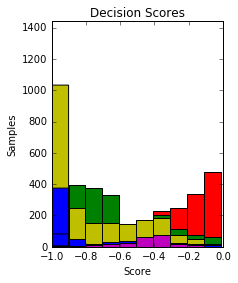

In [37]:
# Plot decision histogram.
plot_range = (twoclass_output.min(), twoclass_output.max())
plt.subplot(122)

plot_colors = 2*"r" + 12*"g" + "y" + 3*"b" + 3*"m"
plot_step = 0.02
class_names = ['qqZvvH125', 'qqWlvH125', 'Wbb', 'Wbc', 'Wcc', 'Wbl', 'Wcl', 'Wl',
               'Zbb', 'Zbc', 'Zcc', 'Zbl', 'Zcl', 'Zl', 'ttbar', 'stopt', 'stops',
               'stopWt', 'WW', 'ZZ', 'WZ']

for n, c in zip(class_names, plot_colors):
    plt.hist(twoclass_output[test_2jet_processes == n],
             bins=10,
             range=plot_range,
             facecolor=c,
             label='%s' % n,
             stacked=True)
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
# plt.legend(loc='upper right')
plt.ylabel('Samples')
plt.xlabel('Score')
plt.title('Decision Scores')

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()

In [21]:
plt.hist

<function matplotlib.pyplot.hist>